# Historic Spotify Chart Analysis
In this notebook, we will analyze the historic Spotify charts to determine recurring christmas songs and artists. The data has been pulled from [Spotifycharts](https://spotifycharts.com/home/) Top 200 Weekly Playlist. Since the charts API has been deprecated and scraping is against their Terms of Service, we'll be using the [historic Spotify charts dataset from Kaggle](https://www.kaggle.com/bartomiejczyewski/spotify-top-200-weekly-global-20172021).

First let's load the data into a pandas dataframe and do some basic data cleaning.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

def read_historic_data(filepath):
  df_h = pd.read_csv(filepath)

  # load the date strings as datetime objects
  df_h["date"] = pd.to_datetime(df_h["Week"])
  df_h = df_h.set_index("date")
  df_h.drop(["Week"], axis=1, inplace=True)

  # drop other dataframe columns that aren't of interest
  df_h.drop(["Explicit", "Track_Number_on_Album", "Artist_Followers", "Duration_MS", "Track_Number_on_Album", "Link", "Album_Name"], axis=1, inplace=True)

  df_h["Artist"] = df_h["Artist"].astype('string')
  df_h["Track"] = df_h["Track"].astype('string').str.lower()

  # convert the Artist_Genres column to lists
  df_h["Artist_Genres"] = df_h["Artist_Genres"].apply(eval)
  return df_h

df = read_historic_data('archive/historicCharts.csv')
df.head()

,Rank,Track,Artist,Streams,Artist_Genres
date,,,,,
2017-01-06,1,starboy,The Weeknd,25734078,"[canadian contemporary r&b, canadian pop, pop]"
2017-01-06,2,closer,The Chainsmokers,23519705,"[dance pop, edm, electropop, pop, pop dance, t..."
2017-01-06,3,rockabye (feat. sean paul & anne-marie),Clean Bandit,21216399,"[dance pop, edm, pop, pop dance, post-teen pop..."
2017-01-06,4,let me love you,DJ Snake,19852704,"[dance pop, edm, electronic trap, pop, pop dance]"
2017-01-06,5,i don’t wanna live forever (fifty shades darke...,ZAYN,18316326,"[dance pop, pop, post-teen pop, uk pop]"


The most frequently played christmas songs, determined by how often they appear in the charts around christmas. By using this method, one hit wonders and songs that just happen to be trending in december are not included (as often). We then filter out all the songs that appear in the charts during other times of the year, to eliminate some remaining outliers. 

<AxesSubplot:title={'center':'Most Popular Christmas Hits on Spotify'}, ylabel='Streams'>

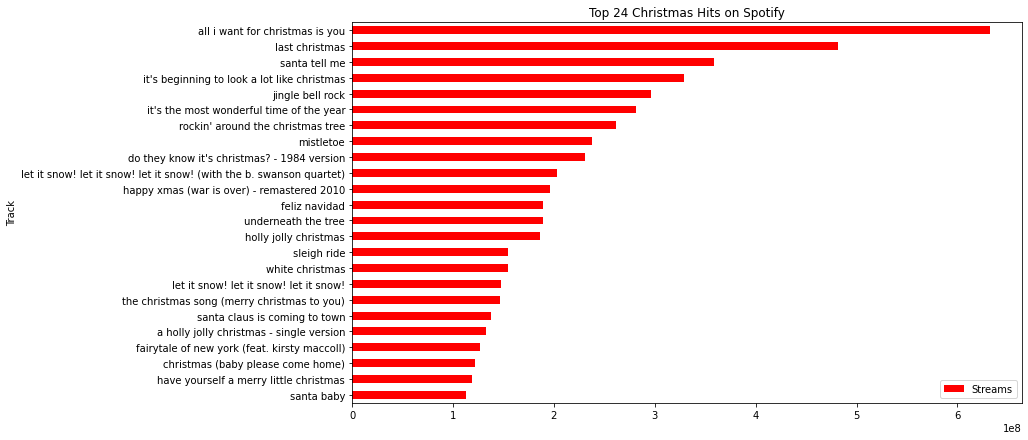

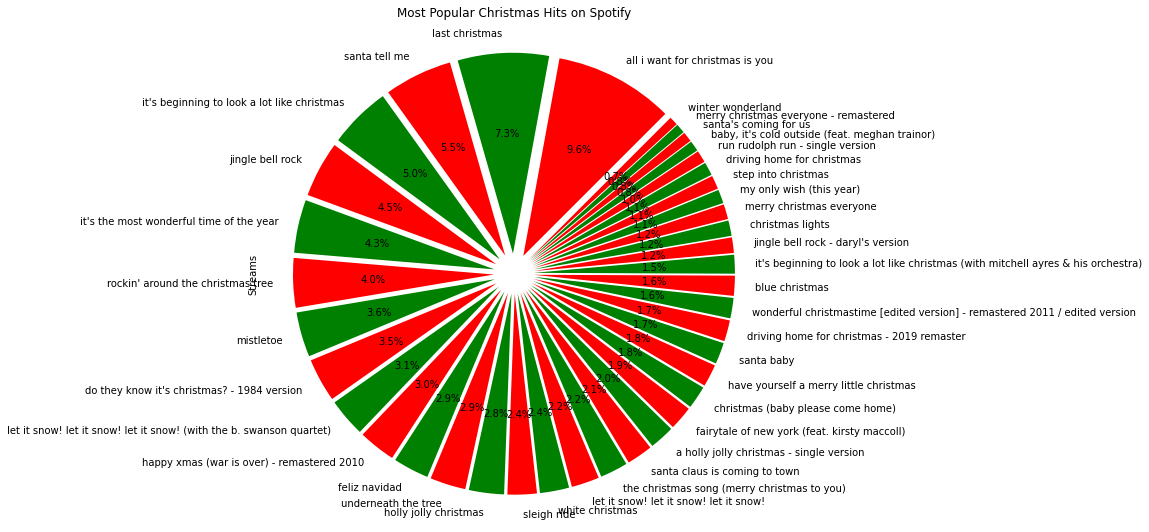

In [2]:
# filter by month (November and December seem to be the time for christmas songs)
songs_to_evaluate = 100
december_hits = df[df.index.month == 12]['Track'].value_counts().index[:songs_to_evaluate].values

# christmas hits are only played around christmas, so we can filter out all the songs that are also played in the other months
non_christmas_months = (df.index.month >= 2 ) & (df.index.month <= 9)
#these are all wrongly identified christmas hits
non_christmas_hits = df[non_christmas_months & df['Track'].isin(december_hits)]

christmas_hits_df = df[df['Track'].isin(december_hits) & ~df['Track'].isin(non_christmas_hits["Track"])]
# Sorted by the total number of streams (while in the charts)
most_popular_hits = christmas_hits_df.groupby('Track').agg({'Streams': 'sum'}).sort_values(by='Streams', ascending=False)

most_popular_hits[:24].sort_values(by='Streams', ascending=True).plot(kind='barh', figsize=(12,7), 
                      title="Top 24 Christmas Hits on Spotify",  color='red')

most_popular_hits.plot(kind='pie', figsize=(9,10), y="Streams", legend=False, 
                      title="Most Popular Christmas Hits on Spotify",  colors=['red', 'green'], 
                      autopct='%.1f%%', explode=(.1,)*most_popular_hits.Streams.count(),
                      startangle=45, )


(-0.5, 399.5, 199.5, -0.5)

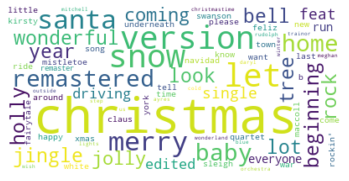

In [3]:
import re
from wordcloud import WordCloud

# The Wordcloud of all the words in the charts
# all_char_songs = df.drop_duplicates(subset=["Track"])["Track"]
# all_char_songs = all_char_songs[~all_char_songs.isnull() ]
# chartcloud = WordCloud(background_color="white").generate(" ".join(all_char_songs.values))

bag_of_words = " ".join(most_popular_hits.index.values)
wordcloud = WordCloud(background_color="white").generate(bag_of_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


## Now let's see how these songs rank throughout the years
First we have to restructure the dataframe to be indexed by date (all weeks from start to finish) and fill the cells with Streams. The names of the christmas hits will be used to adress the columns. By doing this, we can easily plot and compare the songs across years.

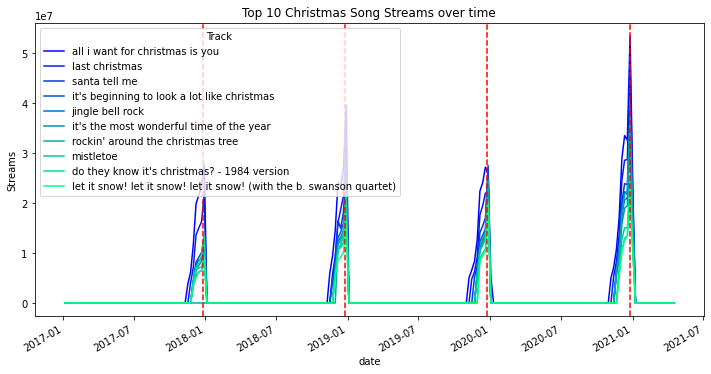

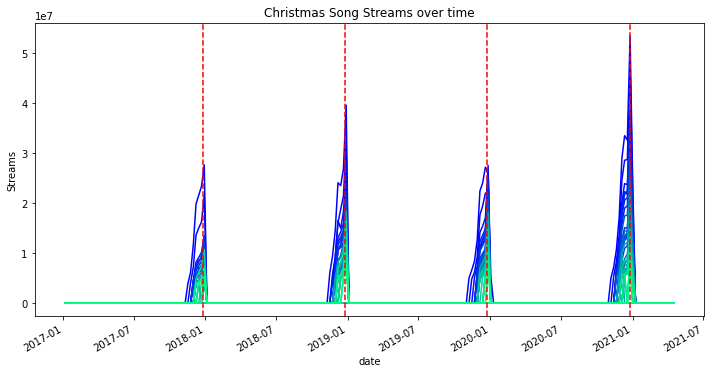

In [5]:
def plot_christmas_streams(input_df, songs_to_plot, inp_title):
  timeline = pd.date_range(start=input_df.index[0], end=input_df.index[-1], freq='W')

  # Figuring out this pivot took me way too long...
  christmas_charts = input_df.pivot_table(columns='Track', values='Streams', index='date', fill_value=0)[songs_to_plot]

  # To plot all the lines, do this:
  timeline_plot = christmas_charts.plot(kind="line", figsize=(12,6), title=inp_title, 
                                        colormap='winter', ylabel='Streams', 
                                        legend=songs_to_plot.size<24)
  for i in range(2017,2021):
    timeline_plot.axvline(x=datetime.datetime(i, 12, 25), color='red', linestyle='--')

plot_christmas_streams(df, most_popular_hits.index[:10], "Top 10 Christmas Song Streams over time")
plot_christmas_streams(df, most_popular_hits.index,"Christmas Song Streams over time")

## The scoring function
Now that we have a rough idea of how christmas hits rank over time, we can develop a scoring function, that analyzes the current charts and returns the current mood. 

The Christmas song multiplier function determines if the song is christmas themed based on the track name. If the song is certainly christmas themed, the multiplier is 1, otherwise it's 0. The function is then multiplied by the number of streams to determine the weighted stream count. To determine that weeks christmas score, we sum the weighted stream counts for all the trending songs and divide by the total number of streams, which is more or less equivalent to the percentage of christmas themed streams of that week. Since we are dividing by the total number of streams, the scoring function is time independent and can be used for daily, weekly, or monthly analysis interchangably.

Text(0, 0.5, 'Percentage of streams')

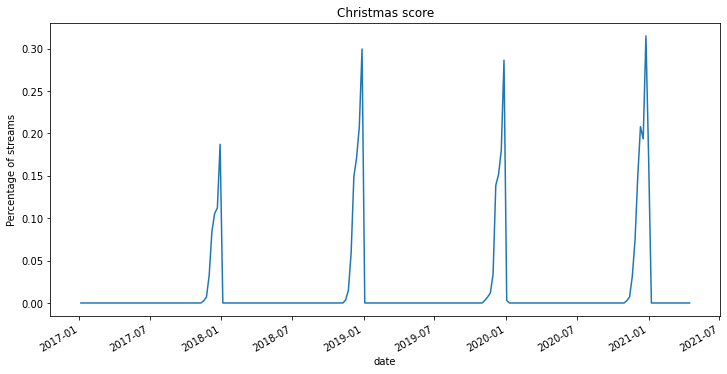

In [6]:
def christmas_score(row):
  return row.sum()

def is_known_christmas_song(song_titles):
  return song_titles.isin(most_popular_hits.index).astype(float)

def song_multipliers(song_titles):
  def title_to_multiplier(title):
    # percentage of words that are classified as christmas themed
    score = 0
    title_words = title.split()
    for word in title_words:
      if word in wordcloud.words_:
        score += wordcloud.words_[word]*2

    score /= len(title_words)
    return score

  return song_titles.to_frame()["Track"].apply(title_to_multiplier)


def df_to_score(inputdf):
  column_df = inputdf.pivot_table(columns='Track', values='Streams', index='date', fill_value=0)
  weighted_column_df = column_df.mul(is_known_christmas_song(column_df.columns), axis=1).apply(christmas_score, axis=1)
  total_streams_df = column_df.apply(lambda x: x.sum(), axis=1)
  return weighted_column_df.div(total_streams_df)

final_score_df = df_to_score(df)

cscore_plt = final_score_df.plot(kind="line", figsize=(12,6))
cscore_plt.set_title("Christmas score")
cscore_plt.set_ylabel("Percentage of streams")

# The top scoring christmas songs by track title
# song_multipliers(column_df.columns).sort_values(ascending=False).head(15)

# Creating a model
We'll use a simple exponential function to model the trends around christmas. Since there christmas songs are only trending in the last few weeks of the year, we'll just model that segment. Without any trending christmas songs, we can't really do any predictions anyway. 

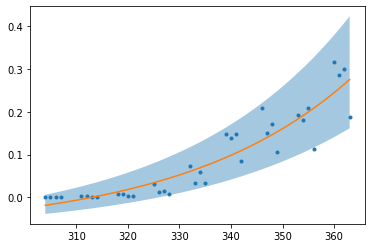

In [7]:
from scipy.optimize import curve_fit

# choose the input and output variables
data_for_model = final_score_df.dropna()[final_score_df.index.dayofyear > 300]
x = np.asarray(data_for_model.index.dayofyear, float)
y = data_for_model.values

smooth_x = np.linspace(x.min(), x.max(), 1000)

def exponential(x, a, b, c):
    return a*np.exp(b*x) + c

fit_parameters, cov = curve_fit(exponential, x, y, p0=[.2, .05, 310])
fit_err = np.sqrt(np.diag(cov))
fit_err *= .05 # really high uncertainty, so we'll only show a 5% std deviation

plt.plot(x, y, '.')
plt.plot(smooth_x, exponential(smooth_x, *fit_parameters))
plt.fill_between(x=smooth_x, 
  y1=exponential(smooth_x, *(fit_parameters + fit_err)), 
  y2=exponential(smooth_x, *(fit_parameters - fit_err)), alpha=0.4)

Now that we have a mathematical model, we can find the roots of the polynomial to determine where we are in time (the x axis). Negative values mean that we before christmas, positive values mean we are in the new year. Now we just have to convert weeks to days and subtract them from the current date to get the most probable christmas date.

In [8]:
def day_from_score(current_score, min_time=300, max_time=365):
  min_val = 0
  max_val = exponential(max_time, *fit_parameters)
  if(current_score <= min_val):
    return 0 # or maybe rater np.nan to indicate no data?
  elif(current_score >= max_val):
    return max_time
  a,b,c = fit_parameters
  return np.log(current_score/a - c)/b


import datetime
print(datetime.date.today().timetuple().tm_yday, day_from_score(0.08))


319 313.9356674129368


In [41]:
# The daily CSV data is structured differently. 
# This function will bring it into the same format we used throughout the notebook.
def read_current_data(filepath):
  df_c = pd.read_csv(filepath,skiprows = 1)
  date_string = re.search(r'\d{4}-\d{2}-\d{2}', filepath).group(0)
  # load the date strings as datetime objects
  df_c["date"] = pd.to_datetime(date_string)
  df_c = df_c.set_index("date")

  # drop other dataframe columns that aren't of interest
  df_c.drop(["URL"], axis=1, inplace=True)
  df_c.rename(columns={"Track Name": "Track"}, inplace=True)

  df_c["Artist"] = df_c["Artist"].astype('string')
  df_c["Track"] = df_c["Track"].astype('string').str.lower()
  return df_c

import os

path = os.path.realpath(os.getcwd()+"/archive")

files= list(os.walk(path))[0][2]
for f in files:
  if(re.match(r"regional-global-daily-",f)):
    file_df = read_current_data(path+"//"+f)
    predicted_day = day_from_score(df_to_score(file_df)[0])
    real_day = file_df.index[0].dayofyear
    print("day: \t", real_day," predicted day: \t", predicted_day, "error: \t",real_day - predicted_day)


day: 	 347  predicted day: 	 347.13057560996657 error: 	 -0.13057560996657003
day: 	 348  predicted day: 	 349.59257214532226 error: 	 -1.592572145322265
day: 	 349  predicted day: 	 338.11692182516515 error: 	 10.88307817483485
day: 	 350  predicted day: 	 339.5865658190216 error: 	 10.413434180978413
day: 	 351  predicted day: 	 341.90686175185243 error: 	 9.093138248147568
day: 	 352  predicted day: 	 345.91834967074755 error: 	 6.081650329252454
day: 	 353  predicted day: 	 349.1961395356302 error: 	 3.803860464369791
day: 	 354  predicted day: 	 353.7180613615151 error: 	 0.28193863848491674
day: 	 355  predicted day: 	 355.027026693204 error: 	 -0.02702669320399309
day: 	 356  predicted day: 	 351.0523874581335 error: 	 4.9476125418664765
day: 	 357  predicted day: 	 352.88939511723476 error: 	 4.110604882765244
day: 	 358  predicted day: 	 365 error: 	 -7
day: 	 359  predicted day: 	 365 error: 	 -6
day: 	 360  predicted day: 	 365 error: 	 -5
day: 	 361  predicted day: 	 347.20